In [32]:
import datetime as dt
import urllib
import math
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
# change plot size
plt.rcParams['figure.dpi'] = 200

In [146]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file

#read csv can read urls directly
df = pd.read_csv(link)
# set row indices, only have dates for columns ids
df =df.set_index(["Country/Region","Lat","Long","Province/State"])

d = df.columns[-1]
print(d)
if sum(df[d].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=d)
else:
    data = df

3/10/20
missing samples go back one day


In [147]:
euro = ["Germany","France","Italy","Sweden","Switzerland","Spain","Portugal","Belgium","Iceland","Ireland"]
countries = {"NA":["US","Canada","Mexico"],
             "Asia":["South Korea","Taiwan","Japan"],
             "Middle East":["Iraq","Egypt","Iran"],"Euro":euro,
             "China":"Mainland China",
            "Italy":"Italy","South Korea":"South Korea","US":"US"}
noChin = data.index.levels[0][data.index.levels[0]!="Mainland China"]

4
0.05113269761800875
1.1249486467709469
4
-0.028754796082670134
0.9359339560103204


<Figure size 1200x800 with 0 Axes>

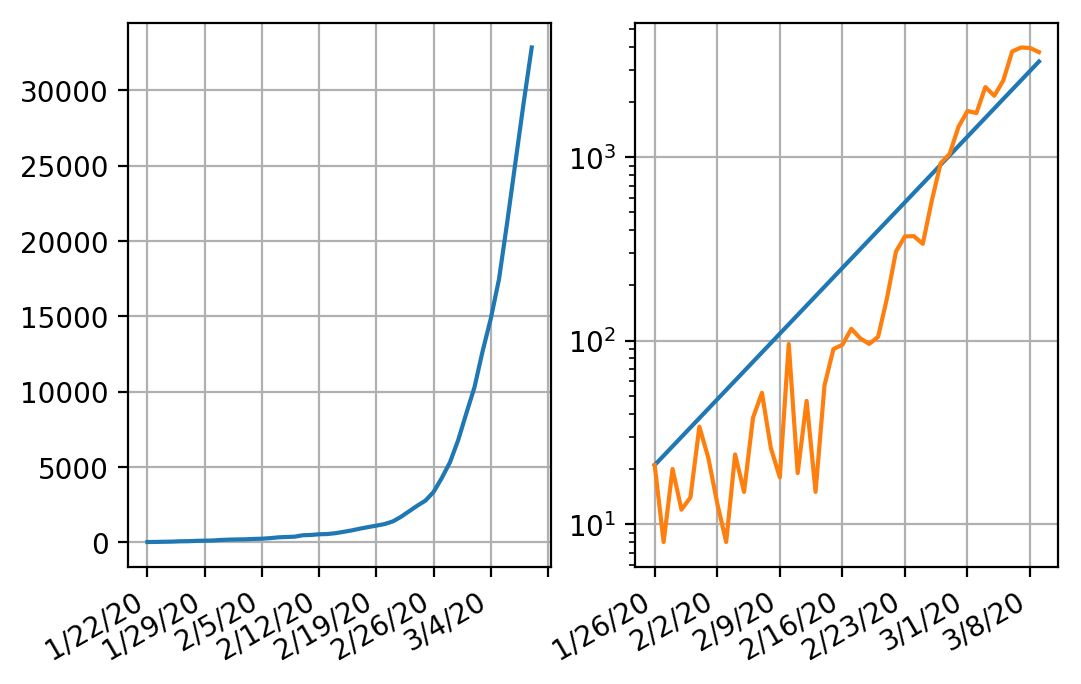

<Figure size 1200x800 with 0 Axes>

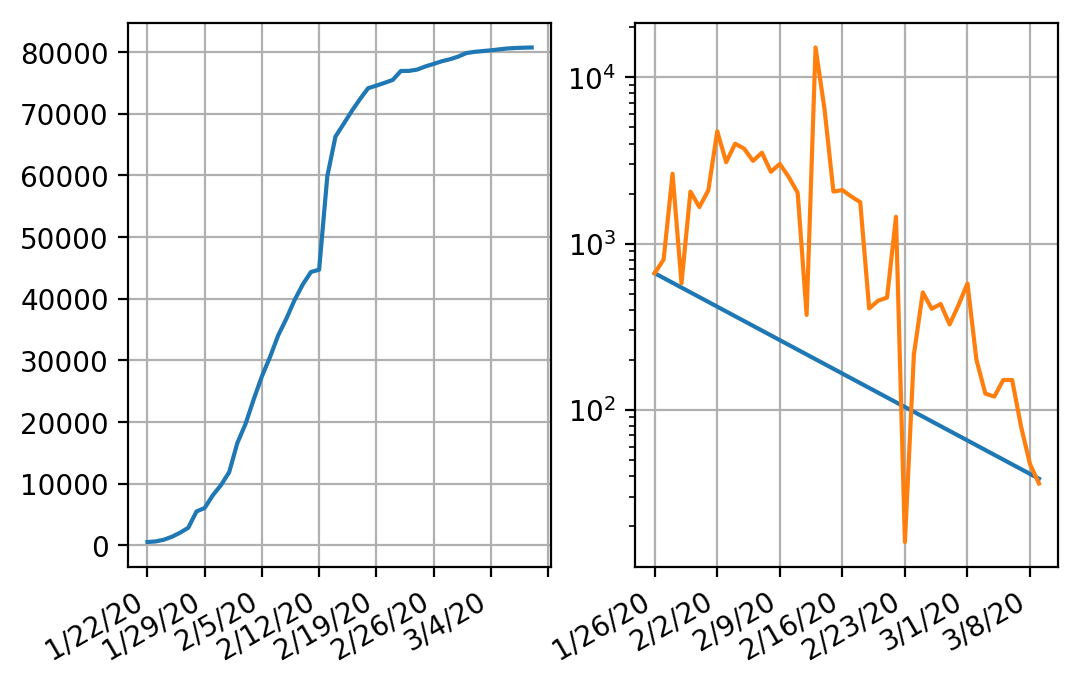

In [148]:
#assume (1+E*P) is 120%
import matplotlib.ticker as mticker

myLocator = mticker.MultipleLocator(7)

#determine slope and plot
for name in [noChin,"Mainland China"]:
    plt.figure()
    vals= data.loc[name].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(lv[-1]-lv[0])/(sp.size(lv))

    print(m)
    print(math.pow(10,m))
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].grid()
    fig.autofmt_xdate()
    #---
    ax[0].plot(data.loc[name].sum())        
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].grid()
    fig.autofmt_xdate()
    
#print(vals.index)
#print(sp.size(lv))

#plt.plot()
#sp.size(vals)
#regressor.fit(vals.index.vals.values)
#vals.index[1].apply(toordinal)
#a = pd.to_datetime(vals.index)
#Xs = pd.to_datetime(vals.index).strftime("%Y%m%d").astype(int)


# Create linear regression object
#from sklearn import datasets, linear_model
#regr = linear_model.LinearRegression()
#regr.fit([Xs],[vals])
#regr.coef_

No handles with labels found to put in legend.


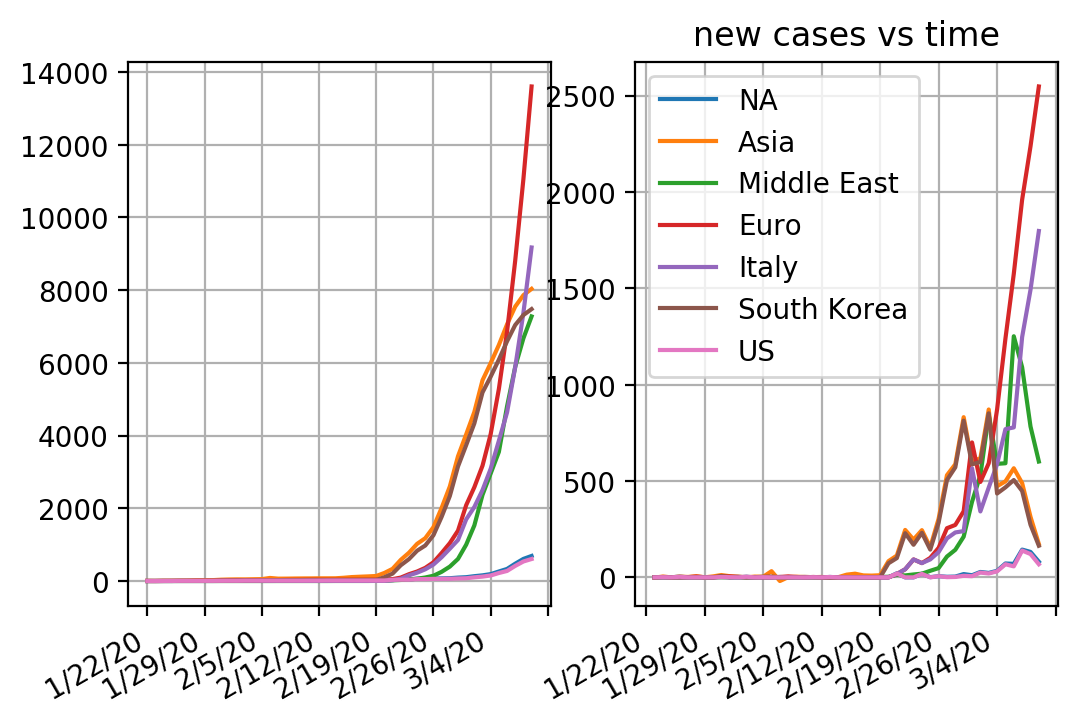

In [149]:

fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    ax[0].plot(data.loc[(country)].sum(),label=name)
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].grid()
plt.legend()
plt.title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals,label=name)
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].grid()
    fig.autofmt_xdate()

plt.legend()
plt.title("new cases vs time");

In [48]:
#raw data
data

1/22/20  1/23/20  1/24/20  \
Country/Region  Lat      Long      Province/State                              
Mainland China  31.82570  117.2264 Anhui                 1        9       15   
                40.18240  116.4142 Beijing              14       22       36   
                30.05720  107.8740 Chongqing             6        9       27   
                26.07890  117.9874 Fujian                1        5       10   
                36.06110  103.8343 Gansu                 0        2        2   
                23.34170  113.4244 Guangdong            26       32       53   
                23.82980  108.7881 Guangxi               2        5       23   
                26.81540  106.8748 Guizhou               1        3        3   
                19.19590  109.7453 Hainan                4        5        8   
                38.04280  114.5149 Hebei                 1        1        2   
                47.86200  127.7615 Heilongjiang          0        2        4   
                33.88202  113.6140 Henan                 5        5        9   
                30.97560  112.2707 Hubei               444      444      549   
                27.61040  111.7088 Hunan                 4        9       24   
                44.09350  113.9448 Inner Mongolia        0        0        1   
                32.97110  119.4550 Jiangsu               1        5        9   
                27.61400  115.7221 Jiangxi               2        7       18   
                43.66610  126.1923 Jilin                 0        1        3   
                41.29560  122.6085 Liaoning              2        3        4   
                37.26920  106.1655 Ningxia               1        1        2   
                35.74520  95.9956  Qinghai               0        0        0   
                35.19170  108.8701 Shaanxi               0        3        5   
                36.34270  118.1498 Shandong              2        6       15   
                31.20200  121.4491 Shanghai              9       16       20   
                37.57770  112.2922 Shanxi                1        1        1   
                30.61710  102.7103 Sichuan               5        8       15   
                39.30540  117.3230 Tianjin               4        4        8   
                31.69270  88.0924  Tibet                 0        0        0   
                41.11290  85.2401  Xinjiang              0        2        2   
                24.97400  101.4870 Yunnan                1        2        5   
...                                                    ...      ...      ...   
US              40.38880 -82.7649  Ohio                  0        0        0   
                41.68090 -71.5118  Rhode Island          0        0        0   
                44.26850 -89.6165  Wisconsin             0        0        0   
Saint Martin    18.07080 -63.0501  NaN                   0        0        0   
US              41.59780 -72.7554  Connecticut           0        0        0   
                21.09430 -157.4983 Hawaii                0        0        0   
                35.56530 -96.9289  Oklahoma              0        0        0   
                40.15000 -111.8624 Utah                  0        0        0   
Burkina Faso    12.23830 -1.5616   NaN                   0        0        0   
Channel Islands 49.37230 -2.3644   NaN                   0        0        0   
Holy See        41.90290  12.4534  NaN                   0        0        0   
Mongolia        46.86250  103.8467 NaN                   0        0        0   
Panama          8.53800  -80.7821  NaN                   0        0        0   
US              38.52660 -96.7265  Kansas                0        0        0   
                31.16950 -91.8678  Louisiana             0        0        0   
                38.45610 -92.2884  Missouri              0        0        0   
                44.04590 -72.7107  Vermont               0        0        0   
                61.37070 -152.4044 Alaska          